# 機械学習スクラッチロジスティック回帰

In [1]:
cd ml_scratch/

/Users/nishiotetsurou/Machine Learning/portfolio/ml-scratch/ml_scratch


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from utils.scaling import ScratchStandardScaler

## 使用するデータセット
150本分のアヤメのデータセット（**Iris-setosa**, **Iris-versicolor**, **Iris-virginica**の３種類の花が入っている。）

In [3]:
df = pd.read_csv('../../../input/iris/iris.csv')

In [4]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
train = df[df['Species'].isin(['Iris-setosa','Iris-versicolor'])]

In [6]:
train.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,5.471000,3.094000,2.862000,0.785000
std,29.011492,0.641698,0.476057,1.448565,0.566288
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,25.750000,5.000000,2.800000,1.500000,0.200000
50%,50.500000,5.400000,3.050000,2.450000,0.800000
75%,75.250000,5.900000,3.400000,4.325000,1.300000
max,100.000000,7.000000,4.400000,5.100000,1.800000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 6 columns):
Id               100 non-null int64
SepalLengthCm    100 non-null float64
SepalWidthCm     100 non-null float64
PetalLengthCm    100 non-null float64
PetalWidthCm     100 non-null float64
Species          100 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 5.5+ KB


上の結果から、欠損値が存在しないデータであり、総数１００本の花のデータであることがわかる。

/Users/nishiotetsurou/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


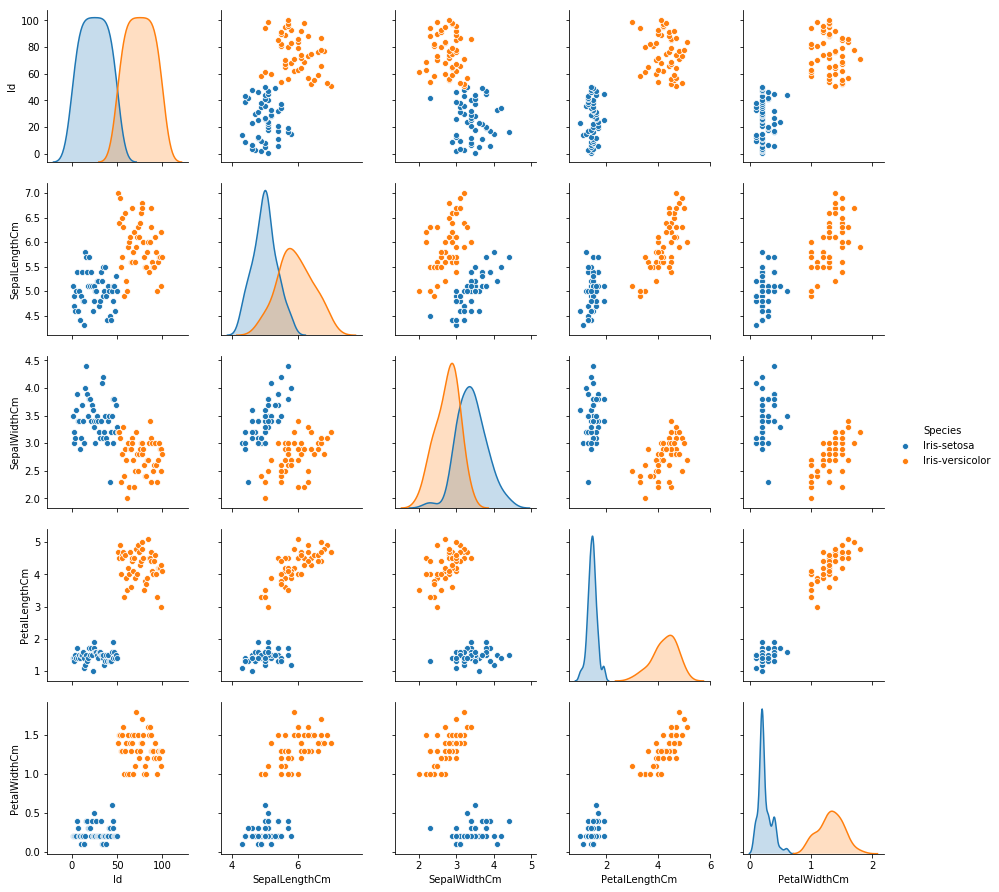

In [8]:
sns.pairplot(train, hue='Species')
plt.show()

どの特徴量を２次元でとっても簡単に線形分離できそう。  
ほとんどデータにばらつきがない。

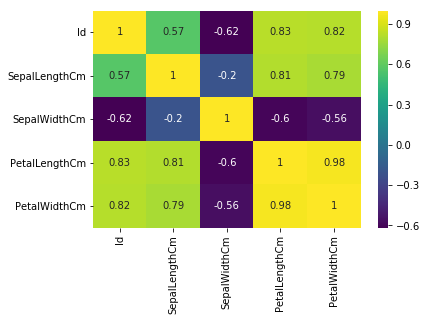

In [9]:
sns.heatmap(train.corr(), cmap='viridis', annot=True)

相関係数マップを作っても同様に、どの特徴量同士も強い相関係数を持っている。

In [10]:
X = train.drop('Species', axis=1)
y = train['Species']

## 層別クロスバリデーションを行う。

In [11]:
import numpy as np
import random
import pandas as pd
train_index =[]
test_index = []
n_cls = y.unique()
train_size=0.8
for clas in n_cls:
    y_index = list(y[y==clas].index)
    sel_num = np.floor(len(y_index) * train_size).astype('int') # trainデータに選ぶサンプル数の決定
    train_num = random.sample(y_index, sel_num) # trainに選ぶインデックスを選択
    test_num = list(set(y_index)-set(train_num))
    train_index.append(train_num)
    test_index.append(test_num)
    
train_index = np.array(train_index).ravel()
test_index = np.array(test_index).ravel()

In [12]:
X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:],  y[train_index], y[test_index] 

In [13]:
print('X_train:shape',format(X_train.shape))
print('y_train:shape',format(y_train.shape))
print('X_test:shape',format(X_test.shape))
print('y_test:shape',format(y_test.shape))

X_train:shape (80, 5)
y_train:shape (80,)
X_test:shape (20, 5)
y_test:shape (20,)


In [14]:
print('y_train')
print(pd.value_counts(y_train))
print('-'*50)
print('y_test')
print(pd.value_counts(y_test))

y_train
Iris-versicolor    40
Iris-setosa        40
Name: Species, dtype: int64
--------------------------------------------------
y_test
Iris-versicolor    10
Iris-setosa        10
Name: Species, dtype: int64


## ロジスティック回帰  

- メリット  
独立変数の尺度や、分布型に対して、厳密な仮定をおいていない。
（線形回帰の場合は正規分布が仮定されている。）

ロジット関数 $y = \log\frac{p}{1-p}$  
ロジット関数の逆関数を求めてみると、

$$
\begin{eqnarray}
    \mathrm{e}^{y} &=& \dfrac{p}{1-p}\\
    p &=& e^y-e^yp\\
    p &=& \dfrac{e^y}{e^y+1}=\dfrac{1}{1+e^{-y}}
\end{eqnarray}
$$
これを書き換えると
$$g(x)=\dfrac{1}{1+e^{-x}}$$

この関数のことを__（標準）ロジスティック関数__という。  
一般に標準ロジスティック関数を拡大縮小移動させたものも含めて__ロジスティック関数__と呼ぶ。

仮に、__ロジット__($\log\frac{p}{1-p}$)を線型結合$\beta_0+\beta_1x_1+\beta_2x_2+\cdots+b_px_p$でおくと、
$$
\begin{eqnarray}
    \log\frac{p}{1-p} = \beta_0+\beta_1x_1+\beta_2x_2+\cdots+b_px_p\\
    p = \dfrac{1}{1+\exp(\beta_0+\beta_1x_1+\beta_2x_2+\cdots+b_px_p)}
\end{eqnarray}
$$
のように表すことができる。  
この関数を使ってロジスティック関数の回帰係数$\beta_0,\beta_1,\beta_2,\cdots+b_p$をデータから決定することで予測モデルを作成することができる。

## ラベルエンコーディング
花の種類が、str型なので数値に変えています。

In [15]:
encoder = LabelEncoder()
y = encoder.fit_transform(y_train)
xsample = X_train.iloc[:,1:3]

In [16]:
standard = ScratchStandardScaler()
standard.fit(xsample)
xsample = standard.transform(xsample)

## シグモイド関数の実装

In [17]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

## ロジスティック関数の実装

In [18]:
def _logistic_hypothesis(X):
    linear = np.dot(X, n_theta)
    logistic = sigmoid(linear)
    return logistic

## コスト関数の算出

In [19]:
def _compute_cost(X, y):
    """
    平均二乗誤差を計算する。MSEは共通の関数を作っておき呼び出す

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値

    Returns
    -------
      次の形のndarray, shape (1,)
      平均二乗誤差
    """
    y_pred = _logistic_hypothesis(X).ravel()
    y = y
    
    return MSE(y_pred, y)

## クロスエントロピー誤差の実装

In [20]:
n_theta = np.random.randn(len(xsample.columns))
y_pred = _logistic_hypothesis(xsample)

In [21]:
def cross_entropy(y_pred, y):
    delta = 1e-4
    cross_entropy = -(y * np.log(y_pred+delta))-(1-y)*np.log(1-y_pred)
    error = np.average(cross_entropy, axis=0)
    return error

In [22]:
cross_entropy(y_pred, y)

0.43862067335022

In [23]:
def cross_entropy(y_pred, y_true) :
    delta = 1e-7
    return -np.sum(y_true*np.log(y_pred+delta))

- L2正則化項

In [24]:
def L2_regular(theta, lam):
    theta_2 = np.square(theta)
    reg = lam*np.average(theta_2, axis=0)
    return reg

In [25]:
theta = np.array([2,3])
L2_regular(theta,0.1)

0.65

In [26]:
theta_2 = np.square(theta)
theta_2

array([4, 9])

In [27]:
np.average(theta_2, axis=0)

6.5

## 勾配降下法

In [28]:
num_iter=13
n_theta =np.array([1,2])
def _gradient_descent(X, y,lam=0.1):
    
    global n_theta
    n_theta = np.random.randn(len(X.columns))
    m = len(X.columns)
    for i in range(num_iter):
        diff = _logistic_hypothesis(X).ravel() - y
        n_theta = n_theta - 0.1 * np.dot((diff - y),xsample)+lam*n_theta/m
        
        
#         print('n_theta:  {}   linear_hypothesis{}'.format(n_theta,_linear_hypothesis(X)[0]))
#         plt.subplot(1,2,1)
#         plt.plot(i,n_theta[0], marker='o')
#         plt.subplot(1,2,2)
#         plt.plot(i, n_theta[1], marker='o')
        
    return n_theta

In [29]:
_gradient_descent(xsample,y)

array([ 56.75122997, -55.94269226])

## スクラッチロジスティック回帰

In [41]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰
    ＊コンストラクタ（__init__）のパラメータはここに書いておくと分かりやすい

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.num_iter = num_iter
        self.lr = lr
        self.verbose = verbose
        self.n_theta = None
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.num_iter)
        self.val_loss = np.zeros(self.num_iter)
        self._coef = np.zeros(self.num_iter)
        
        
    def _logistic_hypothesis(self, X):
        """
        ロジスティック関数の仮定関数を計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        w_x = np.dot(X,self.n_theta)
        sigmoid(w_x)
        return sigmoid(w_x)
    
    def _gradient_descent(self, X, y,lam=0.1):
        """
        最急降下法で重みを更新する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値

        Returns
        -------
          次の形のndarray, shape (1,)

        """
#     self.n_theta = np.random.randn(len(X.columns))
        m = len(X.columns)
        m = float(m)
        for i in range(self.num_iter):
            diff = self._logistic_hypothesis(X).ravel() - y
            self.n_theta = self.n_theta - 0.1 * np.dot((diff - y),xsample)/m + lam * self.n_theta / m
        
        return self.n_theta
        
    def _compute_cost(self, X, y):
        """
        クロスエントロピー誤差を計算する。クロスエントロピー誤差は共通の関数を作っておき呼び出す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値

        Returns
        -------
          次の形のndarray, shape (1,)
          クロスエントロピー
        """
        y_pred = self._logistic_hypothesis(X).ravel()
        print(y_pred)
        return cross_entropy(y_pred, y)
    
        

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。
        検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.n_theta = np.random.randn(len(X.columns))
        for i in range(self.num_iter):
            self._gradient_descent(X, y)
            loss = self._compute_cost(X, y)
            self.loss[i] = loss
            if (X_val is not None) and (y_val is not None):
                val_loss = self._compute_cost(X_val, y_val)
                self.val_loss[i] = val_loss
            else:
                self.val_loss[i] = None
                
            plt.subplot(1,2,1)
            plt.plot(i,self.n_theta[0], marker='o')
            plt.subplot(1,2,2)
            plt.plot(i, self.n_theta[1], marker='o')
            plt.subplots_adjust(wspace=0.5)
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print('[{}]loss:   {} val_loss: {}'.format(i,self.loss[i], self.val_loss[i]))
                print('[{}]coef:   {}'.format(i,self.n_theta))
                print('-'*50)
                
        plt.show()


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """

        predict_proba = self._logistic_hypothesis(X)
        predict_class = np.array([1 if i>=0.5 else 0 for i in predict_proba])
        
        return predict_class

In [42]:
a = ScratchLogisticRegression(num_iter=20, lr=0.01, bias=True, verbose=True)

[7.21200812e-22 1.53712062e-36 2.18908057e-42 3.83310414e-19
 1.02850732e-17 5.19241917e-19 5.05018914e-36 4.91861608e-43
 5.72076091e-48 1.13472029e-36 1.93514261e-20 1.25190178e-55
 3.12615358e-28 1.00171152e-24 5.88187645e-31 8.38816720e-27
 5.19241917e-19 2.19209378e-32 1.61822909e-32 1.53289774e-56
 9.50196075e-39 1.93514261e-20 2.18908057e-42 6.03921674e-24
 6.84111309e-36 2.19209378e-32 6.19224245e-27 1.31977438e-41
 4.92538641e-33 1.93514261e-20 9.50196075e-39 1.02850732e-17
 5.72076091e-48 1.13472029e-36 2.68781540e-23 2.88415617e-59
 6.66288092e-43 5.33131647e-12 3.63597745e-33 1.66380377e-15
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99910183e-01
 1.00000000e+00 1.00000000e+00 9.98223914e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.000000

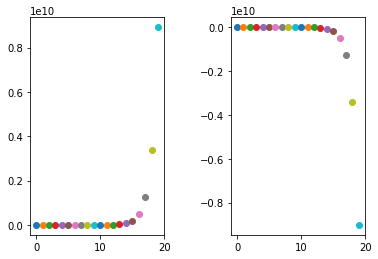

In [43]:
import warnings
warnings.filterwarnings('ignore')

a.fit(xsample,y)

In [44]:
a.predict(xsample)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='feature1', ylabel='feature2', target_names=['1', '-1']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

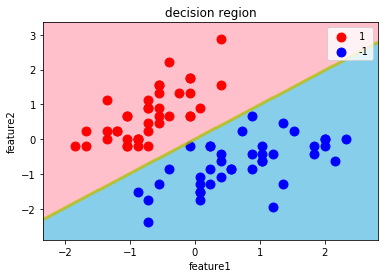

In [50]:
decision_region(xsample.values,y, a, step=0.01, title='decision region', xlabel='feature1', ylabel='feature2', target_names=['1', '-1'])